# Exploratory Data Analysis

Found a few problems with the existing LSTM. It would not predict well, and I will try to find out why in this notebook.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/lora_data_5_6_25.csv")
df.head()

,active_export_low_tariff_Wh,active_export_normal_tariff_Wh,active_import_low_tariff_Wh,active_import_normal_tariff_Wh,applicationID,current_L1_A,current_L2_A,current_L3_A,devEUI,deviceName,gas_meter_volume_L,message_format,meter_timestamp,total_active_export_power_W,total_active_import_power_W,voltage_L1_V,voltage_L2_V,voltage_L3_V
0,779308,1657696,866873,782256,9,8,7,7,70b3d5d72ffcc19f,LHi110,0,7,2025-05-30T14:50:00.000Z,4729,0,231.25,230.25,230.00
1,779308,1658461,866873,782256,9,8,7,7,70b3d5d72ffcc19f,LHi110,0,7,2025-05-30T15:00:00.000Z,4584,0,231.50,230.50,230.25
2,779308,1659275,866873,782256,9,8,7,7,70b3d5d72ffcc19f,LHi110,0,7,2025-05-30T15:10:00.000Z,4886,0,230.25,229.00,229.00
3,779308,1660063,866873,782256,9,8,6,6,70b3d5d72ffcc19f,LHi110,0,7,2025-05-30T15:20:00.000Z,4727,0,230.25,229.00,228.75
4,779308,1662308,866873,782256,9,7,6,6,70b3d5d72ffcc19f,LHi110,0,7,2025-05-30T15:50:00.000Z,4419,0,230.50,228.75,229.25


In [8]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from src.preprocessing import preprocess_data, create_sequences

features = [
    "current_L1_A", "current_L2_A", "current_L3_A",
    "voltage_L1_V", "voltage_L2_V", "voltage_L3_V",
    "total_active_import_power_W", "cost_total_lag1",
    "current_L1_A_lag1", "current_L2_A_lag1", "current_L3_A_lag1",
    "voltage_L1_V_lag1", "voltage_L2_V_lag1", "voltage_L3_V_lag1",
    "total_active_import_power_W_lag1",
    "hour", "minute", "is_weekend",
    "sin_hour", "cos_hour", "sin_minute", "cos_minute",
    "sin_dayofweek", "cos_dayofweek"
]

X_train, X_test, y_train, y_test, x_scaler, y_scaler = preprocess_data("../data/lora_data_5_6_25.csv")

X_train_df = pd.DataFrame(X_train[:, -1, :], columns=features)
X_test_df  = pd.DataFrame(X_test[:, -1, :], columns=features)
y_train_df = pd.DataFrame(y_train)
y_test_df  = pd.DataFrame(y_test)

X_train_df['cost_total'] = y_train_df.values
X_test_df['cost_total'] = y_test_df.values

preprocessed = pd.concat([X_train_df, X_test_df], axis=0, ignore_index=True)
preprocessed.head()

,current_L1_A,current_L2_A,current_L3_A,voltage_L1_V,voltage_L2_V,voltage_L3_V,total_active_import_power_W,cost_total_lag1,current_L1_A_lag1,current_L2_A_lag1,current_L3_A_lag1,voltage_L1_V_lag1,voltage_L2_V_lag1,voltage_L3_V_lag1,total_active_import_power_W_lag1,hour,minute,is_weekend,sin_hour,cos_hour,sin_minute,cos_minute,sin_dayofweek,cos_dayofweek,cost_total
0,0.555556,0.555556,0.750,0.203704,0.181818,0.175439,0.0,0.0,0.666667,0.666667,0.750,0.185185,0.163636,0.140351,0.0,0.695652,0.4,0.0,0.066987,0.25000,1.000000e+00,0.25,0.277479,0.0,0.0
1,0.555556,0.555556,0.625,0.166667,0.163636,0.140351,0.0,0.0,0.555556,0.555556,0.750,0.203704,0.181818,0.175439,0.0,0.695652,0.6,0.0,0.066987,0.25000,5.000000e-01,0.00,0.277479,0.0,0.0
2,0.555556,0.555556,0.625,0.166667,0.163636,0.140351,0.0,0.0,0.555556,0.555556,0.625,0.166667,0.163636,0.140351,0.0,0.695652,0.8,0.0,0.066987,0.25000,1.110223e-16,0.25,0.277479,0.0,0.0
3,0.555556,0.555556,0.625,0.203704,0.181818,0.157895,0.0,0.0,0.555556,0.555556,0.625,0.166667,0.163636,0.140351,0.0,0.695652,1.0,0.0,0.066987,0.25000,0.000000e+00,0.75,0.277479,0.0,0.0
4,0.555556,0.555556,0.625,0.259259,0.254545,0.245614,0.0,0.0,0.555556,0.555556,0.625,0.203704,0.181818,0.157895,0.0,0.739130,0.0,0.0,0.017037,0.37059,5.000000e-01,1.00,0.277479,0.0,0.0


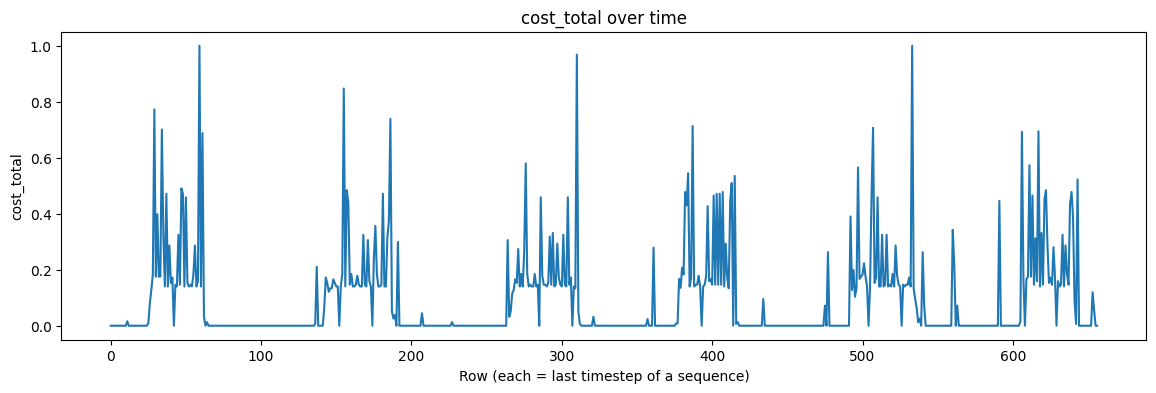

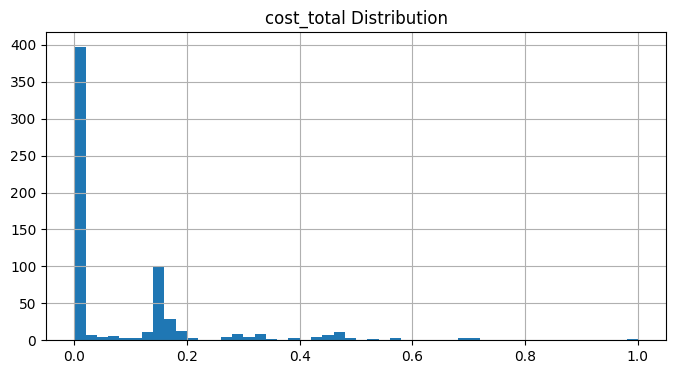

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(preprocessed['cost_total'])
plt.title('cost_total over time')
plt.xlabel('Row (each = last timestep of a sequence)')
plt.ylabel('cost_total')
plt.show()

preprocessed['cost_total'].hist(bins=50, figsize=(8,4))
plt.title('cost_total Distribution')
plt.show()

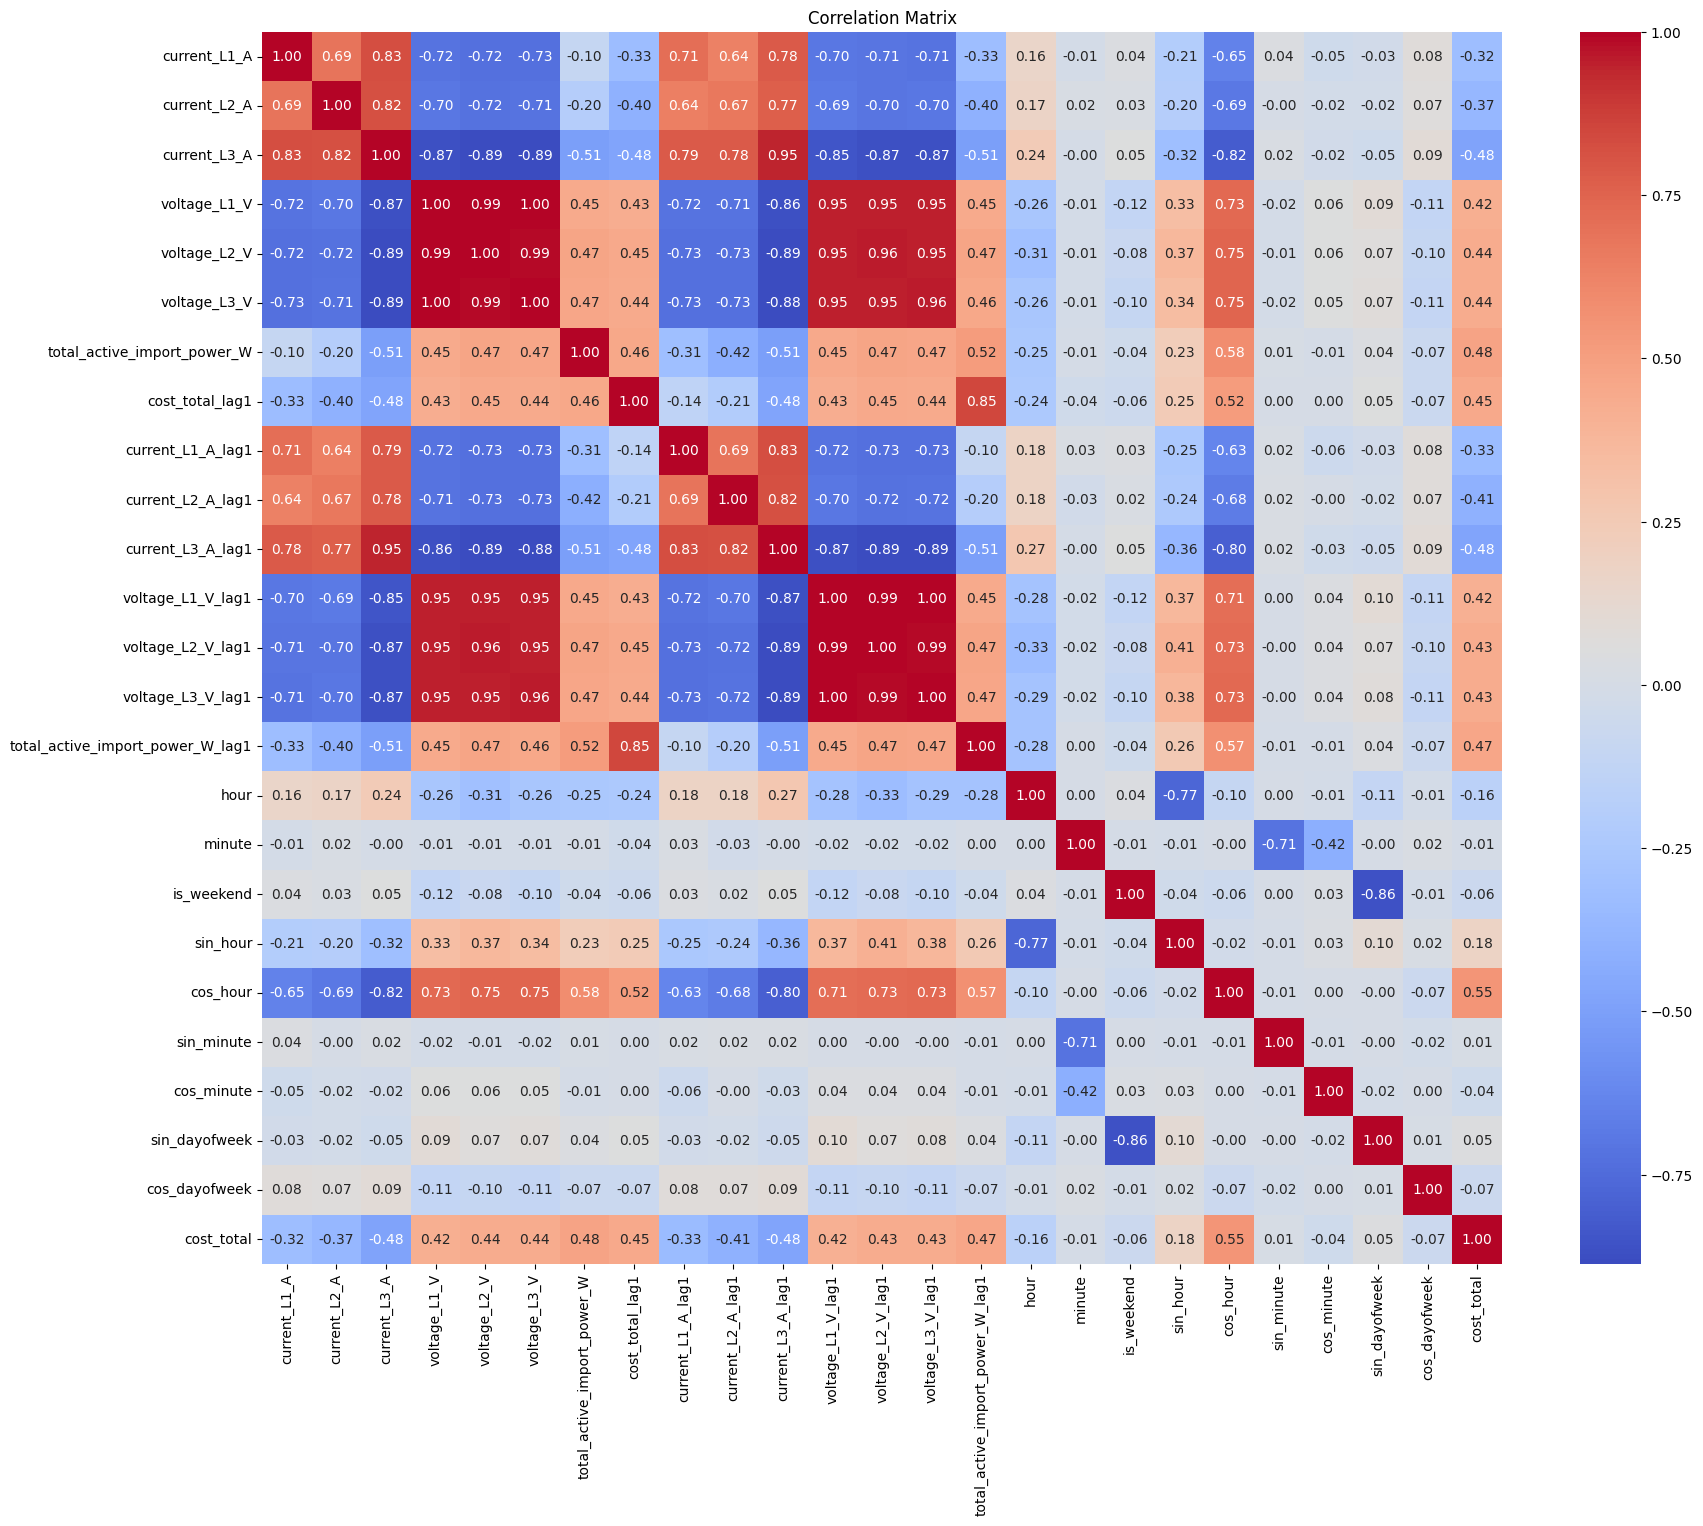

cost_total                          1.000000
cos_hour                            0.548263
total_active_import_power_W         0.482850
total_active_import_power_W_lag1    0.466062
cost_total_lag1                     0.454581
voltage_L2_V                        0.438871
voltage_L3_V                        0.435721
voltage_L2_V_lag1                   0.433186
voltage_L3_V_lag1                   0.433009
voltage_L1_V                        0.421447
voltage_L1_V_lag1                   0.416546
sin_hour                            0.176212
sin_dayofweek                       0.046557
sin_minute                          0.006731
minute                             -0.005258
cos_minute                         -0.039721
is_weekend                         -0.061718
cos_dayofweek                      -0.066970
hour                               -0.162246
current_L1_A                       -0.321046
current_L1_A_lag1                  -0.333857
current_L2_A                       -0.365076
current_L2

In [15]:
import seaborn as sns

plt.figure(figsize=(20,16))
sns.heatmap(preprocessed.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

# Focused correlations with target
print(preprocessed.corr()['cost_total'].sort_values(ascending=False))


What We See

    The target, cost_total, does not have any strong correlation (absolute value > 0.5) with any feature.

    Most correlations with cost_total are between -0.4 and +0.45 (moderate at best).

    The highest correlations with cost_total are:

        cost_total_lag1 (0.45) — which is still not very high.

        total_active_import_power_W (0.43)

        Some current and voltage lags (but still weak).

    Time and cyclical features (hour, minute, sin_hour, etc.) have almost no correlation with the target.

What This Means

    No strong predictors: Your model does not have access to any feature that strongly predicts the target.

    LSTM won’t help: LSTMs need temporal structure or strongly correlated features. Here, even lags don’t correlate highly with the target.

    Model learns “average” behavior: With no strong signals, the safest output is always close to the mean or recent values—exactly what you observed.

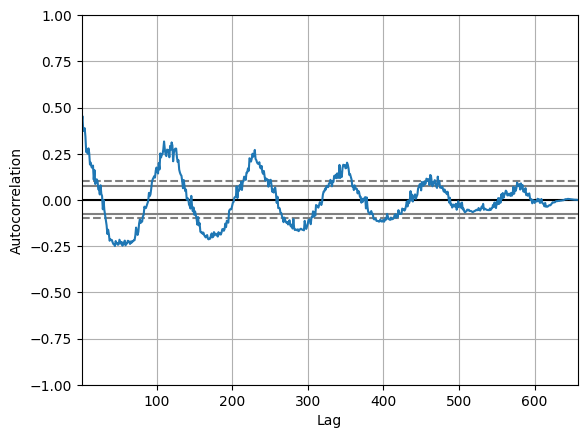

In [20]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(preprocessed['cost_total'])
plt.show()

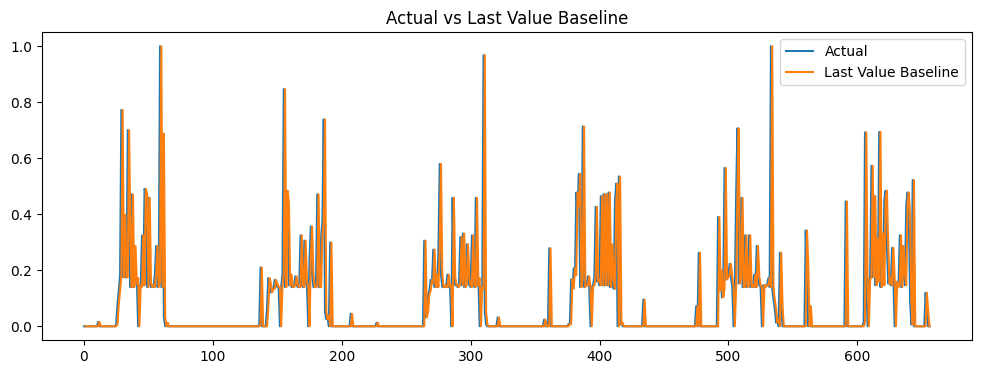

In [21]:
preprocessed['cost_total_last'] = preprocessed['cost_total'].shift(1)
plt.figure(figsize=(12,4))
plt.plot(preprocessed['cost_total'], label='Actual')
plt.plot(preprocessed['cost_total_last'], label='Last Value Baseline')
plt.legend()
plt.title('Actual vs Last Value Baseline')
plt.show()


## Basically we need a new concept

In [23]:
import pandas as pd

df = pd.read_csv("../data/lora_data_5_6_25.csv", parse_dates=["meter_timestamp"])
df = df.set_index("meter_timestamp")
print(df.info())
print(df.describe())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 671 entries, 2025-05-30 14:50:00+00:00 to 2025-06-05 09:30:00+00:00
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   active_export_low_tariff_Wh     671 non-null    int64  
 1   active_export_normal_tariff_Wh  671 non-null    int64  
 2   active_import_low_tariff_Wh     671 non-null    int64  
 3   active_import_normal_tariff_Wh  671 non-null    int64  
 4   applicationID                   671 non-null    int64  
 5   current_L1_A                    671 non-null    int64  
 6   current_L2_A                    671 non-null    int64  
 7   current_L3_A                    671 non-null    int64  
 8   devEUI                          671 non-null    object 
 9   deviceName                      671 non-null    object 
 10  gas_meter_volume_L              671 non-null    int64  
 11  message_format                  671 non-null    

In [24]:
print(df.isnull().sum())
print("Duplicates:", df.duplicated().sum())

active_export_low_tariff_Wh       0
active_export_normal_tariff_Wh    0
active_import_low_tariff_Wh       0
active_import_normal_tariff_Wh    0
applicationID                     0
current_L1_A                      0
current_L2_A                      0
current_L3_A                      0
devEUI                            0
deviceName                        0
gas_meter_volume_L                0
message_format                    0
total_active_export_power_W       0
total_active_import_power_W       0
voltage_L1_V                      0
voltage_L2_V                      0
voltage_L3_V                      0
dtype: int64
Duplicates: 31


In [25]:
print("Before:", df.shape)
df = df.drop_duplicates()
print("After:", df.shape)

Before: (671, 17)
After: (640, 17)


In [26]:
dupes = df.index.duplicated().sum()
print("Duplicate timestamps in index:", dupes)

Duplicate timestamps in index: 0


## EDA 2

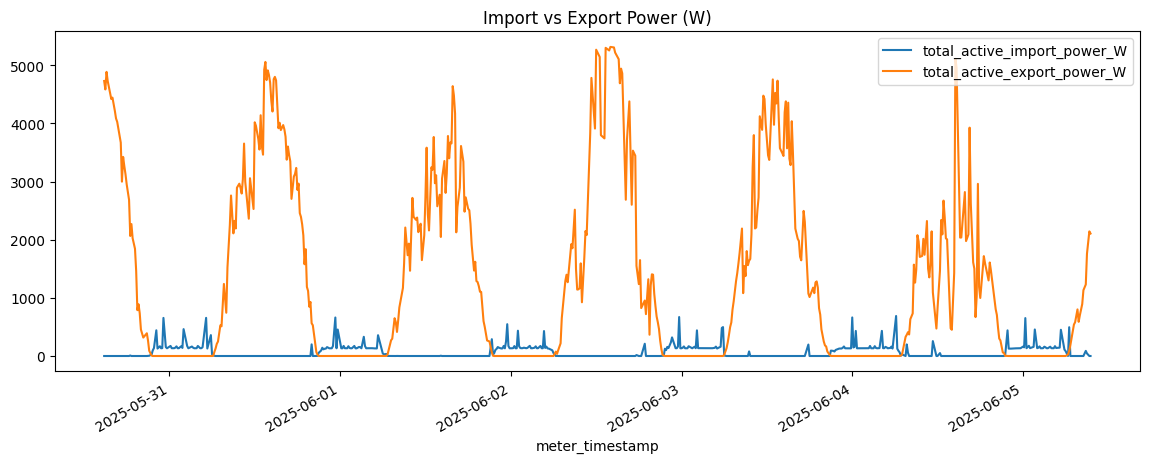

In [27]:
df[['total_active_import_power_W', 'total_active_export_power_W']].plot(figsize=(14,5))
plt.title('Import vs Export Power (W)')
plt.show()


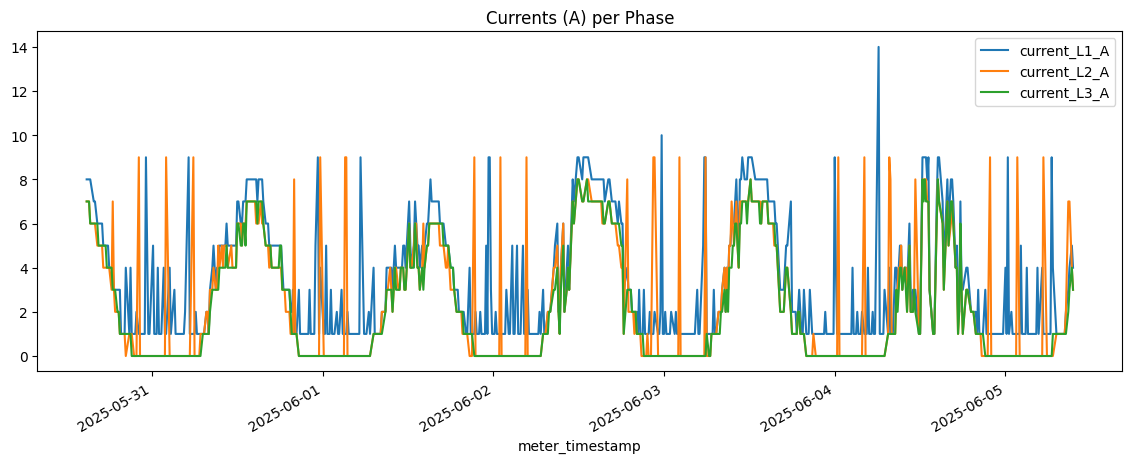

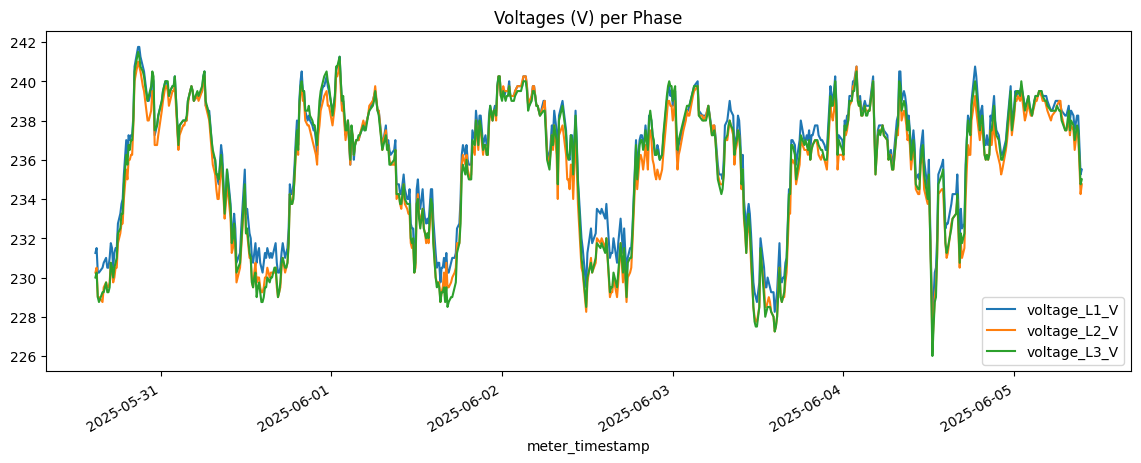

In [28]:
df[['current_L1_A', 'current_L2_A', 'current_L3_A']].plot(figsize=(14,5))
plt.title('Currents (A) per Phase')
plt.show()

df[['voltage_L1_V', 'voltage_L2_V', 'voltage_L3_V']].plot(figsize=(14,5))
plt.title('Voltages (V) per Phase')
plt.show()


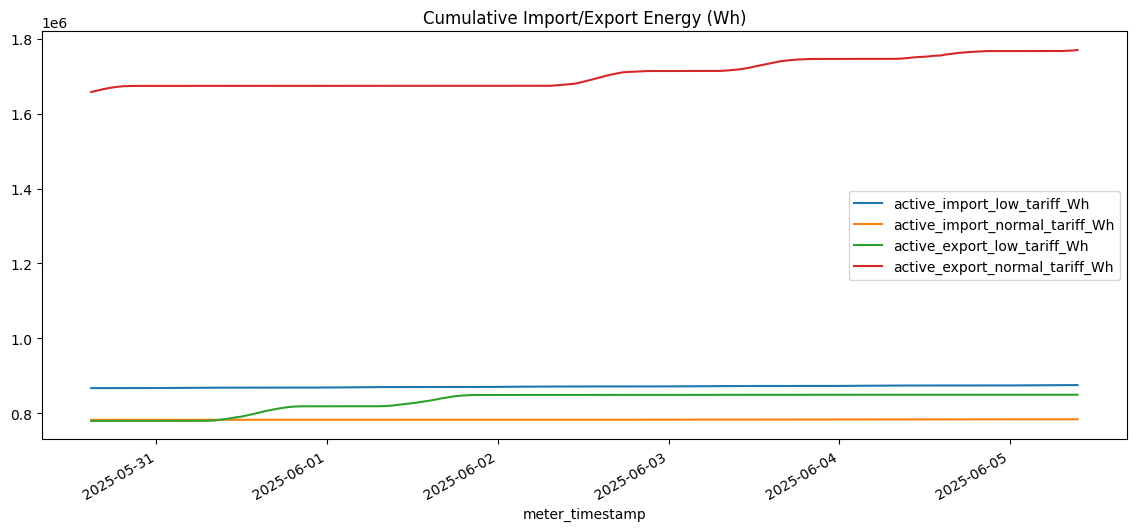

In [29]:
df[['active_import_low_tariff_Wh', 'active_import_normal_tariff_Wh',
    'active_export_low_tariff_Wh', 'active_export_normal_tariff_Wh']].plot(figsize=(14,6))
plt.title('Cumulative Import/Export Energy (Wh)')
plt.show()


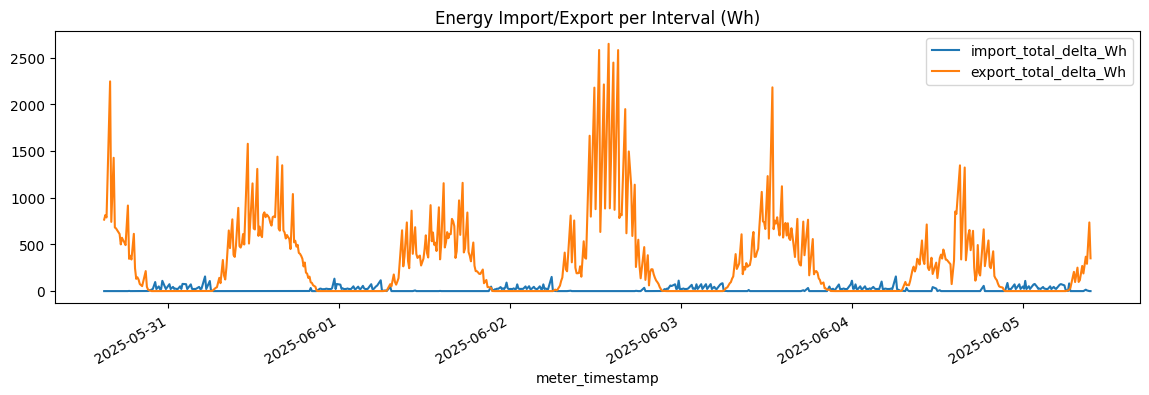

In [30]:
df['import_total_delta_Wh'] = df['active_import_low_tariff_Wh'].diff().clip(lower=0) + \
                              df['active_import_normal_tariff_Wh'].diff().clip(lower=0)
df['export_total_delta_Wh'] = df['active_export_low_tariff_Wh'].diff().clip(lower=0) + \
                              df['active_export_normal_tariff_Wh'].diff().clip(lower=0)
df['gas_delta_L'] = df['gas_meter_volume_L'].diff().clip(lower=0)

df[['import_total_delta_Wh', 'export_total_delta_Wh']].plot(figsize=(14,4))
plt.title('Energy Import/Export per Interval (Wh)')
plt.show()

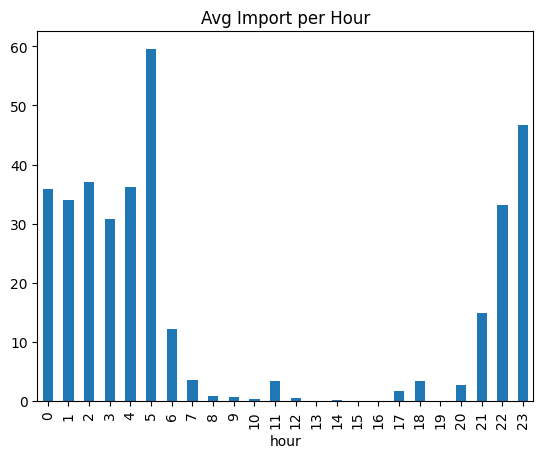

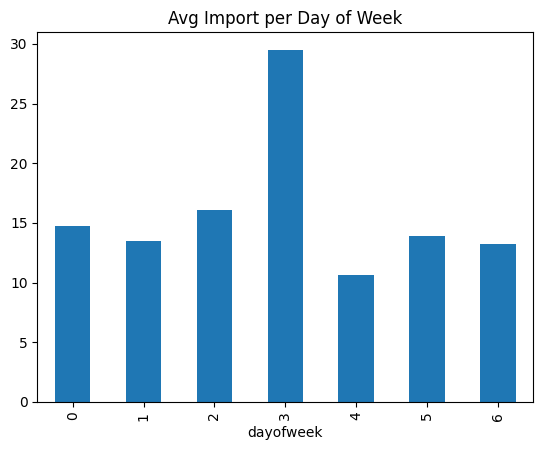

In [31]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

df.groupby('hour')['import_total_delta_Wh'].mean().plot(kind='bar', title='Avg Import per Hour')
plt.show()
df.groupby('dayofweek')['import_total_delta_Wh'].mean().plot(kind='bar', title='Avg Import per Day of Week')
plt.show()


Possible scenarios:

    Night-time equipment or charging:
    Heavy energy-consuming processes, machinery, or charging (e.g., EVs, industrial processes, or building systems) operate almost exclusively at night.

    Building unoccupied during the day:
    Maybe you’re monitoring a facility that is closed or inactive most of the day, or most consumption is shifted intentionally to night (e.g., to save on energy costs with night tariffs).

    Load shifting:
    If you’re using dynamic tariffs, loads may be scheduled at night when electricity is cheaper.

    Measurement or logging issue:
    If this seems strange, double-check your timestamps (timezones, DST shifts, logging intervals) to rule out any alignment issues.

Potential import spikes: 13


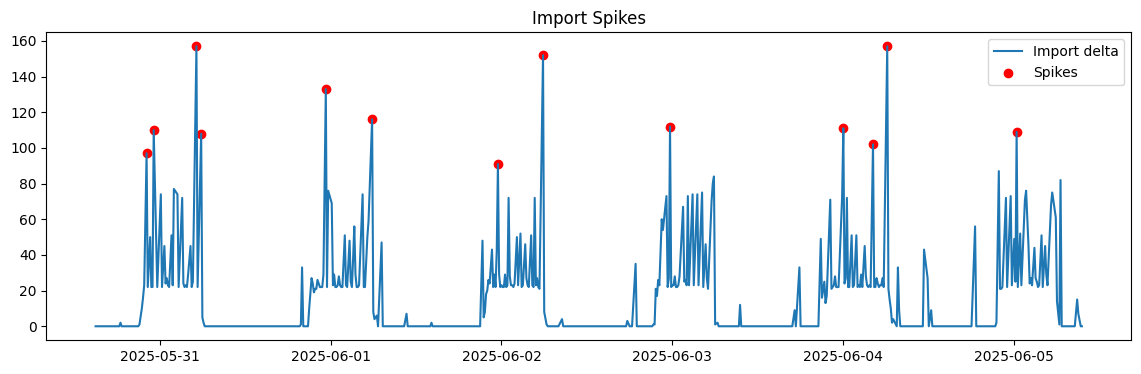

In [32]:
threshold = df['import_total_delta_Wh'].mean() + 3 * df['import_total_delta_Wh'].std()
spikes = df[df['import_total_delta_Wh'] > threshold]
print("Potential import spikes:", spikes.shape[0])
plt.figure(figsize=(14,4))
plt.plot(df['import_total_delta_Wh'], label='Import delta')
plt.scatter(spikes.index, spikes['import_total_delta_Wh'], color='red', label='Spikes')
plt.legend()
plt.title('Import Spikes')
plt.show()


In [33]:
print("Total electricity imported (kWh):", df['import_total_delta_Wh'].sum() / 1000)
print("Peak import in any interval (Wh):", df['import_total_delta_Wh'].max())
print("Total gas used (L):", df['gas_delta_L'].sum())


Total electricity imported (kWh): 9.551
Peak import in any interval (Wh): 157.0
Total gas used (L): 0.0


### Some ML baselines to figure out what would work with current data and what would add business value.

#### 1. Anomaly detection with Isolation Forest

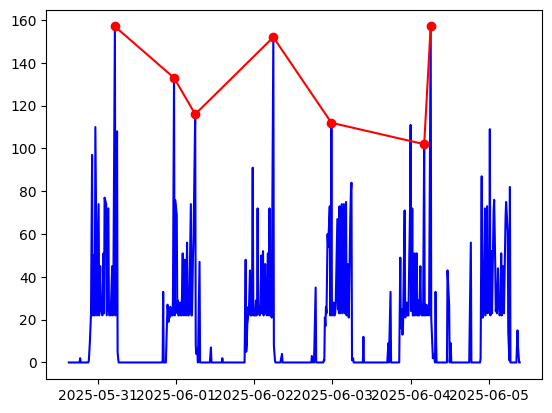

In [34]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Use your interval (delta) column, e.g., import_total_delta_Wh
X = df[['import_total_delta_Wh']].fillna(0)

iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_score'] = iso.fit_predict(X)
df['is_anomaly'] = df['anomaly_score'] == -1

# Show on dashboard (pseudocode)
plt.plot(df.index, df['import_total_delta_Wh'], color='blue')
plt.plot(df[df['is_anomaly']].index, df[df['is_anomaly']]['import_total_delta_Wh'], color='red', marker='o')

plt.show()


#### 2. Predictive insights

In [41]:
from sklearn.ensemble import RandomForestRegressor

# Create lag features
for lag in range(1, 7):  # Previous 6 intervals
    df[f'lag_{lag}'] = df['import_total_delta_Wh'].shift(lag)
df = df.dropna()

# Prepare features/target
features = [f'lag_{lag}' for lag in range(1, 7)] + ['hour', 'dayofweek']
X = df[features]
y = df['import_total_delta_Wh']

# Train/test split (simple, not production-ready)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model = RandomForestRegressor(n_estimators=400, random_state=42)
model.fit(X_train, y_train)
df.loc[X_test.index, 'predicted'] = model.predict(X_test)

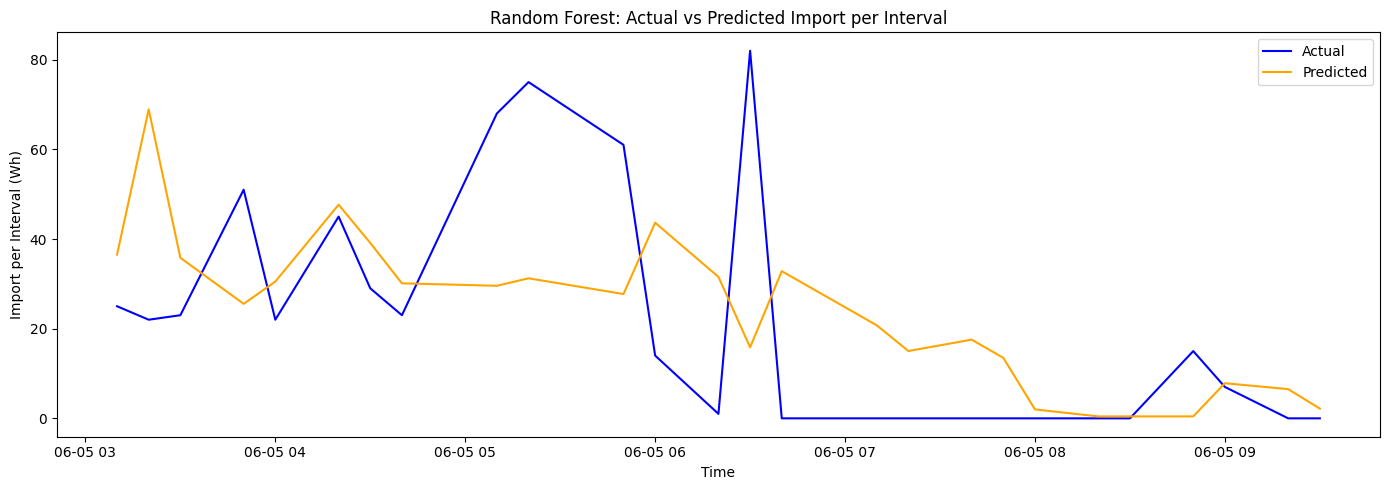

In [42]:
import matplotlib.pyplot as plt

# Make sure you have predictions in your DataFrame as 'predicted'
# If not, do: df.loc[X_test.index, 'predicted'] = model.predict(X_test)

plt.figure(figsize=(14,5))
plt.plot(df.loc[X_test.index].index, y_test, label="Actual", color="blue")
plt.plot(df.loc[X_test.index].index, df.loc[X_test.index, 'predicted'], label="Predicted", color="orange")
plt.title("Random Forest: Actual vs Predicted Import per Interval")
plt.xlabel("Time")
plt.ylabel("Import per Interval (Wh)")
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("MAE:", mean_absolute_error(y_test, df.loc[X_test.index, 'predicted']))
print("MSE:", mean_squared_error(y_test, df.loc[X_test.index, 'predicted']))
print("R²:", r2_score(y_test, df.loc[X_test.index, 'predicted']))


MAE: 13.02172864187431
MSE: 536.8138442769094
R²: 0.22279499481051268


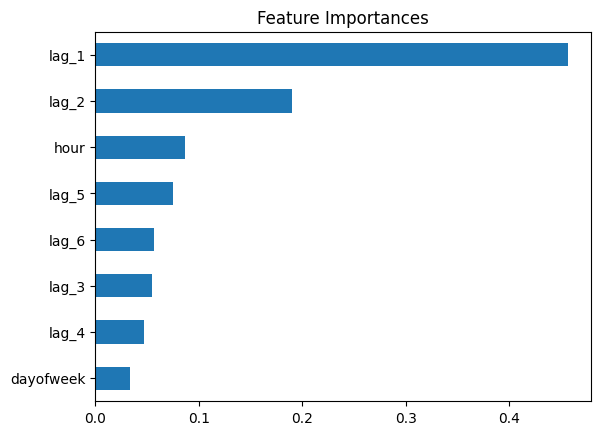

In [40]:
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=features)
feature_importance.sort_values().plot(kind='barh', title='Feature Importances')
plt.show()
